# Time Series KMeans

In [1]:
import os
import numpy as np
import pandas as pd
import japanize_matplotlib
import matplotlib.pyplot as plt

In [2]:
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

In [3]:
# -1〜+1の間に規格化 :ToDo
def normalize(score):
    norm = (score-score.min())/(score.max()-score.min()) # 0-1に規格化
    norm = norm * 2
    norm = norm - np.mean(norm, axis=0)
    return norm

In [4]:
# 分類されたクラスタを表示
def show_cluster(tm_kmeans, suptitle, title, n_row=3, n_col=3):
    center = tm_kmeans.cluster_centers_[:,:,0]
    plt.figure(figsize=(15, 10))
    plt.suptitle(suptitle, fontsize=20)
    for i in np.arange(len(center)):
        ax = plt.subplot(n_row, n_col, i+1)
        ax.set_title(f'{title}:{i+1}', fontsize=15)
        ax.plot(center[i])
    plt.tight_layout()
    plt.show()

In [5]:
class AozoraTSKmeas:

    def __init__(self, n_clusters, metrics='dtw', random_state=0):
        self.tskmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=metrics, random_state=random_state)

    def fit_transform(self, A):
        self.distances = self.tskmeans.fit_transform(A)
    
    # 分類されたクラスタを表示
    def show_cluster(self, suptitle, title, n_row=3, n_col=3):
        center = self.tskmeans.cluster_centers_[:,:,0]
        plt.figure(figsize=(15, 10))
        plt.suptitle(suptitle, fontsize=20)
        for i in np.arange(len(center)):
            ax = plt.subplot(n_row, n_col, i+1)
            ax.set_title(f'{title}:{i+1}', fontsize=15)
            ax.plot(center[i])
        plt.tight_layout()
        plt.show()

    # クラスタとクラスタに近いデータを表示
    """
    Parameters
    ----------
    aozora_data: 作家，作品，スコアを含むデータフレーム
    disp_num: クラスタに近いインスタンスの表示数
    label_num: ラベル表示数
    """
    def show_cluster_sumples(self, aozora_data,
                            disp_num=20, label_num=5, 
                            figsize=(15, 15), plot_rows=3, plot_cols=3):
        n_clusters = len(np.unique(self.tskmeans.labels_)) 
        plt.figure(figsize=figsize)
        suptitle = f'tslearn.clustering.TimeSeriesKMeans [metric:dtw][n_clusters={n_clusters}]'
        plt.suptitle(suptitle, fontsize=20)
        for label in range(n_clusters):
            keys = np.where(self.tskmeans.labels_==label)[0]
            values = self.distances[self.tskmeans.labels_==label][:, label]
            distance_dicts = {k: v for k, v in zip(keys, values)}
            distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
            distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
            # print(label, distance_dicts_sort_key[:20])
            # グラフ表示
            cell = label + 1
            ax = plt.subplot(plot_rows, plot_cols, cell)
            count = len(distance_dicts_sort_key)
            top_stories = []
            ax.set_title(f'center{cell} ({count})', fontsize=15)
            for idx in distance_dicts_sort_key[:disp_num]:
                ax.plot(A[idx], alpha=.5, c='gray')
                author = aozora_data.iloc[idx].loc['氏名']
                novel = aozora_data.iloc[idx].loc['作品名']
                url = aozora_data.iloc[idx].loc['図書カードURL']
                top_stories.append(f'{novel} ({author})\n{url}')
            xlabel = 'Top Stories:\n'
            for i in range(label_num):
                xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
            ax.set_xlabel(xlabel, loc='left', fontsize=15)
            # ax.set_xlabel('\n'.join(top_stories[:5]), loc='left', fontsize=15)
            plt.plot(self.tskmeans.cluster_centers_[label].ravel(), c='red')
        plt.tight_layout(rect=[0, 0, 1, 0.98])
        plt.show()
    
    # クラスタに近い小説を表示
    """
    Parameters
    ----------
    kmeans: TimeSeriesKMenasのインスタンス
    distances: 中心からの距離
    aozora_data: 作家，作品，スコアを含むデータフレーム
    disp_num: クラスタに近いインスタンスの表示数
    """
    def show_novels(self, aozora_data, disp_num=20):
        n_clusters = len(np.unique(self.tskmeans.labels_)) 
        print(f'CLUSTER NUM:{n_clusters}')
        print('NO: 作品名 [副題] (作者,文の長さ)\n')
        for label in range(n_clusters):
            keys = np.where(self.tskmeans.labels_==label)[0]
            values = self.distances[self.tskmeans.labels_==label][:, label]
            distance_dicts = {k: v for k, v in zip(keys, values)}
            distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
            distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
            # print(label, distance_dicts_sort_key[:20])
            # クラスタに近い小説を表示
            top_stories = []
            for idx in distance_dicts_sort_key[:disp_num]:
                author = aozora_data.iloc[idx].loc['氏名']
                novel = aozora_data.iloc[idx].loc['作品名']
                subtitle = aozora_data.iloc[idx].loc['副題']
                url = aozora_data.iloc[idx].loc['図書カードURL']
                length = int(aozora_data.iloc[idx].loc['length'])
                if type(subtitle) is float:
                    top_stories.append(f'{novel} ({author},{length})\n{url}')
                else:
                    top_stories.append(f'{novel} [{subtitle}] ({author},{length})\n{url}')
            xlabel = f'Top Stories of center{label+1}:\n'
            for i in range(disp_num):
                xlabel = xlabel + f'{str(i+1).zfill(2)}: {top_stories[i]}\n'
            print(xlabel)

In [6]:
# 使うデータは1036冊分の小説データの感情スコア値
SCORE_PATH = 'data/all_score_0630.csv'
TARGET_PATH = 'data/target2.csv'

In [7]:
# スコアファイル読み込み
score_df = pd.read_csv(SCORE_PATH, index_col=0)
score_df.head()

S00       S01       S02       S03       S04       S05       S06  \
13  0.791536  0.737968  0.829343  0.794293  0.724665  0.707668  0.620669   
24  0.749562  0.727724  0.721075  0.648729  0.764811  0.627247  0.634754   
30  0.473785  0.473785  0.652944  0.622040  0.663769  0.799352  0.982744   
41  0.900899  0.952689  1.000000  0.928408  0.802310  0.760143  0.699925   
47  0.742317  0.836033  0.890097  0.911625  0.967501  0.967501  0.972570   

         S07       S08       S09  ...       S90       S91       S92       S93  \
13  0.607199  0.584499  0.626389  ...  0.754139  0.782878  0.784226  0.576965   
24  0.640822  0.792777  0.844474  ...  0.690379  0.640809  0.828280  0.806064   
30  0.966812  0.851591  0.907304  ...  0.101549  0.142406  0.285570  0.270750   
41  0.759109  0.660739  0.726829  ...  0.094422  0.246499  0.291265  0.373439   
47  0.982321  1.000000  0.929571  ...  0.202141  0.256933  0.256933  0.243298   

         S94       S95       S96       S97       S98       S99  
13  0.534152  0.601299  0.612696  0.611167  0.664706  0.736535  
24  0.754045  0.906671  0.896347  0.869153  0.901117  0.933473  
30  0.320434  0.441094  0.464494  0.548101  0.610829  0.517892  
41  0.445357  0.450839  0.390509  0.337263  0.402609  0.459209  
47  0.175068  0.204548  0.171354  0.173879  0.108680  0.023454  

[5 rows x 100 columns]

In [8]:
# ターゲットファイル読み込み
target_df = pd.read_csv(TARGET_PATH, index_col=0)
target_df.head(2)

対象  人物ID      氏名            読み   作品ID    作品名   副題        作品名読み  \
0  True   374   饗庭 篁村      あえば こうそん  45754     良夜  NaN         りょうや   
1  True   879  芥川 竜之介  あくたがわ りゅうのすけ     73  或敵打の話  NaN  あるかたきうちのはなし   

                                            図書カードURL  \
0  https://www.aozora.gr.jp/cards/000374/card4575...   
1  https://www.aozora.gr.jp/cards/000879/card73.html   

                                         テキストファイルURL  \
0  https://www.aozora.gr.jp/cards/000374/files/45...   
1  https://www.aozora.gr.jp/cards/000879/files/73...   

                                          テキストファイルパス  \
0  ./bunko/cards/000374/files/edit/45754_ruby_236...   
1   ./bunko/cards/000879/files/edit/73_ruby_1217.txt   

                                           スコアファイルパス   備考  length  
0  ./bunko/cards/000374/files/score/45754_ruby_23...  NaN   119.0  
1  ./bunko/cards/000879/files/score/73_ruby_1217.txt  NaN   280.0

In [9]:
# ターゲットファイルとスコアファイルをマージ
df_merge_all = pd.merge(target_df, score_df, left_index=True, right_index=True)
df_merge_all.head(3)

対象  人物ID      氏名            読み  作品ID     作品名   副題     作品名読み  \
13  True   879  芥川 竜之介  あくたがわ りゅうのすけ   124  お律と子等と  NaN   おりつとこらと   
24  True   879  芥川 竜之介  あくたがわ りゅうのすけ    77   奇怪な再会  NaN  きかいなさいかい   
30  True   879  芥川 竜之介  あくたがわ りゅうのすけ    38    戯作三昧  NaN   げさくざんまい   

                                             図書カードURL  \
13  https://www.aozora.gr.jp/cards/000879/card124....   
24  https://www.aozora.gr.jp/cards/000879/card77.html   
30  https://www.aozora.gr.jp/cards/000879/card38.html   

                                          テキストファイルURL  ...       S90  \
13  https://www.aozora.gr.jp/cards/000879/files/12...  ...  0.754139   
24  https://www.aozora.gr.jp/cards/000879/files/77...  ...  0.690379   
30  https://www.aozora.gr.jp/cards/000879/files/38...  ...  0.101549   

         S91       S92       S93       S94       S95       S96       S97  \
13  0.782878  0.784226  0.576965  0.534152  0.601299  0.612696  0.611167   
24  0.640809  0.828280  0.806064  0.754045  0.906671  0.896347  0.869153   
30  0.142406  0.285570  0.270750  0.320434  0.441094  0.464494  0.548101   

         S98       S99  
13  0.664706  0.736535  
24  0.901117  0.933473  
30  0.610829  0.517892  

[3 rows x 114 columns]

In [10]:
# Indexを列として出して，振り直し
df_merge = df_merge_all.reset_index()
df_merge = df_merge.rename(columns={'index': 'TargetID'})
df_merge.head()

TargetID    対象  人物ID      氏名            読み  作品ID     作品名   副題     作品名読み  \
0        13  True   879  芥川 竜之介  あくたがわ りゅうのすけ   124  お律と子等と  NaN   おりつとこらと   
1        24  True   879  芥川 竜之介  あくたがわ りゅうのすけ    77   奇怪な再会  NaN  きかいなさいかい   
2        30  True   879  芥川 竜之介  あくたがわ りゅうのすけ    38    戯作三昧  NaN   げさくざんまい   
3        41  True   879  芥川 竜之介  あくたがわ りゅうのすけ    59     邪宗門  NaN   じゃしゅうもん   
4        47  True   879  芥川 竜之介  あくたがわ りゅうのすけ   155      少年  NaN     しょうねん   

                                            図書カードURL  ...       S90       S91  \
0  https://www.aozora.gr.jp/cards/000879/card124....  ...  0.754139  0.782878   
1  https://www.aozora.gr.jp/cards/000879/card77.html  ...  0.690379  0.640809   
2  https://www.aozora.gr.jp/cards/000879/card38.html  ...  0.101549  0.142406   
3  https://www.aozora.gr.jp/cards/000879/card59.html  ...  0.094422  0.246499   
4  https://www.aozora.gr.jp/cards/000879/card155....  ...  0.202141  0.256933   

        S92       S93       S94       S95       S96       S97       S98  \
0  0.784226  0.576965  0.534152  0.601299  0.612696  0.611167  0.664706   
1  0.828280  0.806064  0.754045  0.906671  0.896347  0.869153  0.901117   
2  0.285570  0.270750  0.320434  0.441094  0.464494  0.548101  0.610829   
3  0.291265  0.373439  0.445357  0.450839  0.390509  0.337263  0.402609   
4  0.256933  0.243298  0.175068  0.204548  0.171354  0.173879  0.108680   

        S99  
0  0.736535  
1  0.933473  
2  0.517892  
3  0.459209  
4  0.023454  

[5 rows x 115 columns]

In [11]:
# スコアだけ表示してみる
df_merge.loc[:,'S00':]

S00       S01       S02       S03       S04       S05       S06  \
0     0.791536  0.737968  0.829343  0.794293  0.724665  0.707668  0.620669   
1     0.749562  0.727724  0.721075  0.648729  0.764811  0.627247  0.634754   
2     0.473785  0.473785  0.652944  0.622040  0.663769  0.799352  0.982744   
3     0.900899  0.952689  1.000000  0.928408  0.802310  0.760143  0.699925   
4     0.742317  0.836033  0.890097  0.911625  0.967501  0.967501  0.972570   
...        ...       ...       ...       ...       ...       ...       ...   
1031  1.000000  0.886321  0.760418  0.683147  0.649745  0.606923  0.571151   
1032  0.928336  1.000000  0.946976  0.868300  0.888023  0.706569  0.560303   
1033  1.000000  0.909603  0.793596  0.745868  0.727928  0.758194  0.740752   
1034  0.528431  0.438392  0.438334  0.539294  0.604325  0.652928  0.757941   
1035  1.000000  0.936297  0.894863  0.804954  0.771635  0.654813  0.599213   

           S07       S08       S09  ...       S90       S91       S92  \
0     0.607199  0.584499  0.626389  ...  0.754139  0.782878  0.784226   
1     0.640822  0.792777  0.844474  ...  0.690379  0.640809  0.828280   
2     0.966812  0.851591  0.907304  ...  0.101549  0.142406  0.285570   
3     0.759109  0.660739  0.726829  ...  0.094422  0.246499  0.291265   
4     0.982321  1.000000  0.929571  ...  0.202141  0.256933  0.256933   
...        ...       ...       ...  ...       ...       ...       ...   
1031  0.517130  0.492479  0.494035  ...  0.180267  0.172682  0.146108   
1032  0.661318  0.782652  0.888690  ...  0.472828  0.545340  0.500948   
1033  0.763606  0.817574  0.829033  ...  0.687817  0.752808  0.738397   
1034  0.918232  0.951555  0.909684  ...  0.440108  0.449598  0.485174   
1035  0.558161  0.495424  0.486509  ...  0.501346  0.473209  0.441937   

           S93       S94       S95       S96       S97       S98       S99  
0     0.576965  0.534152  0.601299  0.612696  0.611167  0.664706  0.736535  
1     0.806064  0.754045  0.906671  0.896347  0.869153  0.901117  0.933473  
2     0.270750  0.320434  0.441094  0.464494  0.548101  0.610829  0.517892  
3     0.373439  0.445357  0.450839  0.390509  0.337263  0.402609  0.459209  
4     0.243298  0.175068  0.204548  0.171354  0.173879  0.108680  0.023454  
...        ...       ...       ...       ...       ...       ...       ...  
1031  0.091107  0.070645  0.042570  0.032390  0.094500  0.142480  0.098496  
1032  0.563695  0.563695  0.697739  0.767883  0.759698  0.974234  0.763724  
1033  0.750526  0.830493  0.896725  0.919508  0.899834  0.873144  0.925176  
1034  0.381715  0.325619  0.357203  0.409554  0.360593  0.315495  0.401312  
1035  0.478669  0.486706  0.501930  0.510489  0.528429  0.556842  0.533268  

[1036 rows x 100 columns]

In [12]:
scores = df_merge.loc[:,'S00':].to_numpy()
# scores = score_df.to_numpy()

In [13]:
# 平均値を０にしておく(-1〜1の間に規格化)
A = normalize(scores)
# A = scores - scores.mean(axis=0)
A.shape, np.min(A), np.max(A), np.mean(A)

((1036, 100), -1.1071332471188664, 1.0698986010803475, -4.020807710804621e-18)

In [14]:
# 軸を追加しておく
A = A[:,:,np.newaxis]
A.shape

(1036, 100, 1)

## metric:euclidean

In [15]:
km1 = TimeSeriesKMeans(n_clusters=9, metric='euclidean', random_state=0)
km1.fit(A)

TimeSeriesKMeans(n_clusters=9, random_state=0)

In [16]:
km1.cluster_centers_.shape

(9, 100, 1)

In [17]:
center1 = km1.cluster_centers_[:,:,0]
center1.shape

(9, 100)

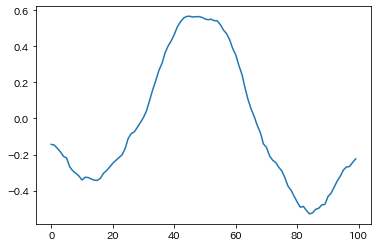

In [18]:
plt.plot(center1[2])

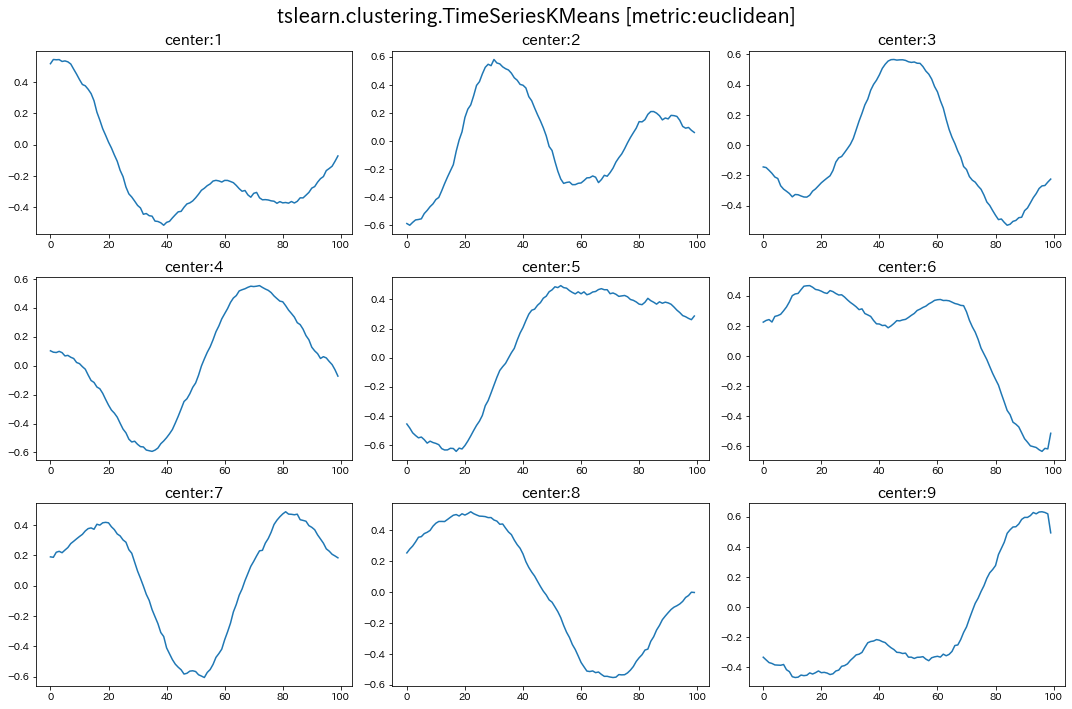

In [19]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:euclidean]'
show_cluster(km1, suptitle, 'center')

## metric:dtw

In [20]:
km2 = TimeSeriesKMeans(n_clusters=9, metric='dtw', random_state=0)
km2.fit(A)

TimeSeriesKMeans(metric='dtw', n_clusters=9, random_state=0)

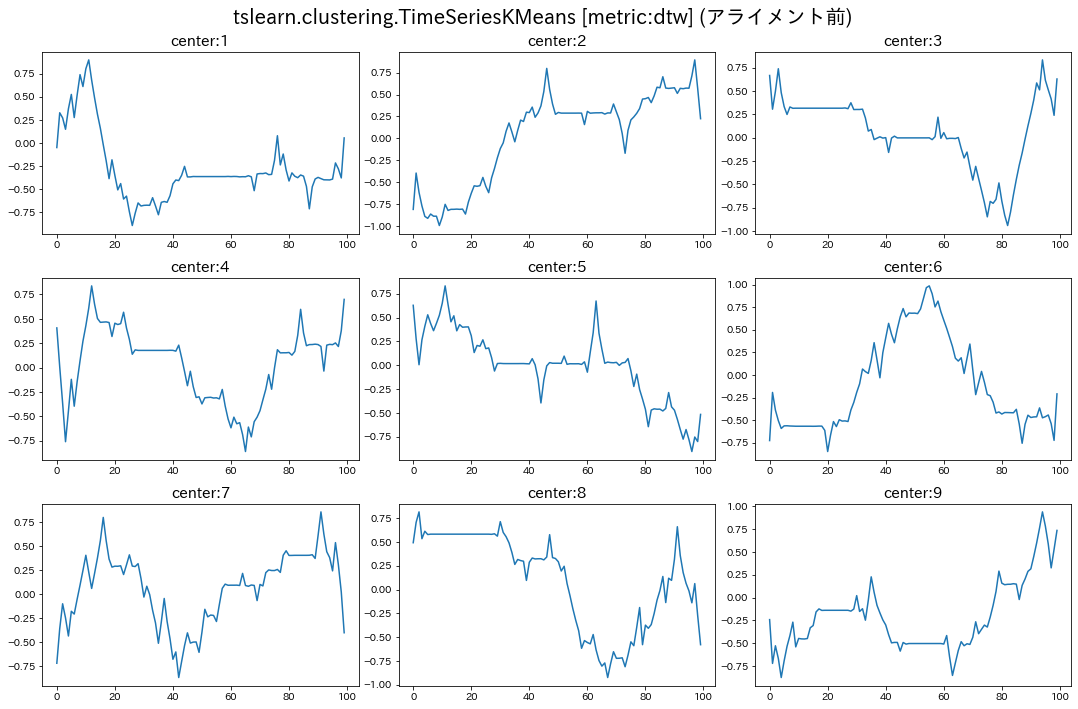

In [21]:
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] (アライメント前)'
show_cluster(km2, suptitle, 'center')

In [22]:
np.unique(km2.labels_)

array([0, 1, 2, 3, 4, 5, 6, 7, 8])

In [23]:
km2_pred = km2.predict(A)

In [24]:
distances = km2.transform(A)
distances.shape

(1036, 9)

In [25]:
np.where(km2.labels_==0)[0].shape

(91,)

In [26]:
keys = np.where(km2.labels_==0)[0]
values = distances[km2.labels_==0][:, 0]
distance_dicts = {k: v for k, v in zip(keys, values)}
distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
# np.where(km2.labels_==0)[0], distances[km2.labels_==0][:, 0]

In [27]:
distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
print(distance_dicts_sort_key[:20])

[715, 355, 607, 436, 864, 200, 314, 633, 293, 960, 861, 153, 1034, 36, 964, 654, 663, 509, 487, 925]


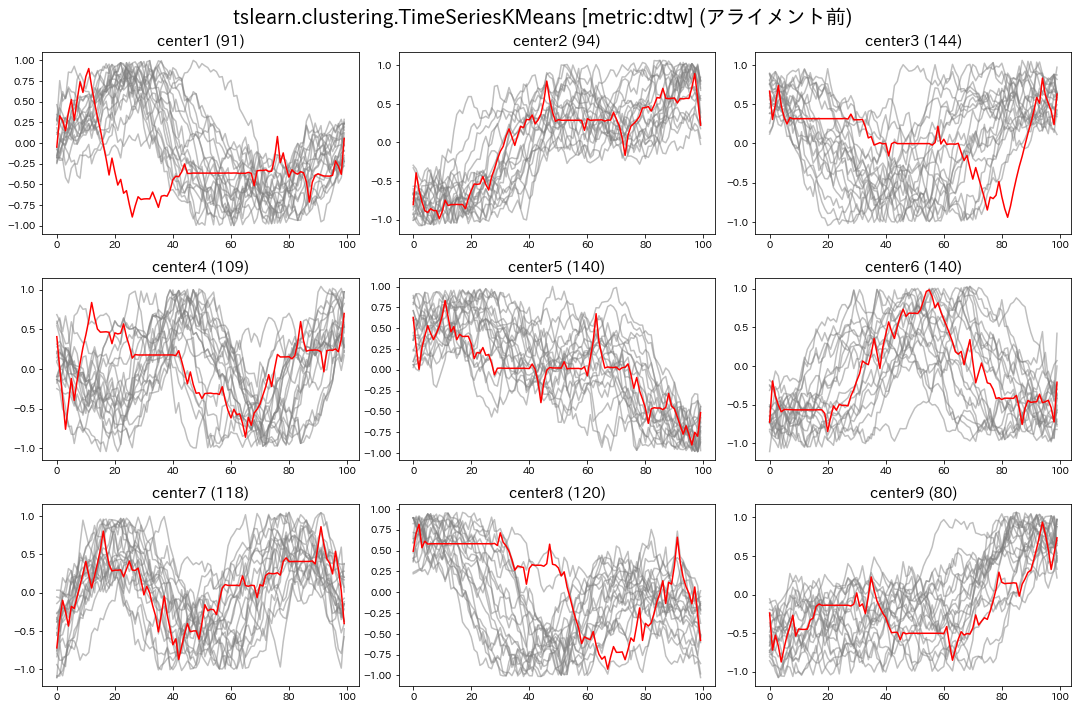

In [28]:
n_clusters = len(np.unique(km2.labels_)) 
disp_num = 20
plt.figure(figsize=(15, 10))
plt.suptitle('tslearn.clustering.TimeSeriesKMeans [metric:dtw] (アライメント前)', fontsize=20)
for label in range(n_clusters):
    keys = np.where(km2.labels_==label)[0]
    values = distances[km2.labels_==label][:, label]
    distance_dicts = {k: v for k, v in zip(keys, values)}
    distance_dicts_sort = sorted(distance_dicts.items(), key=lambda x:x[1])
    distance_dicts_sort_key = [dict[0] for dict in distance_dicts_sort]
    # print(label, distance_dicts_sort_key[:20])
    # グラフ表示
    cell = label + 1
    ax = plt.subplot(3, 3, cell)
    count = len(distance_dicts_sort_key)
    ax.set_title(f'center{cell} ({count})', fontsize=15)    
    for idx in distance_dicts_sort_key[:disp_num]:
        ax.plot(A[idx], alpha=.5, c='gray')
    plt.plot(km2.cluster_centers_[label].ravel(), c='red')
plt.tight_layout()
plt.show()

## metric:softdtw

In [29]:
# 遅いです．．
km3 = TimeSeriesKMeans(n_clusters=9, metric='softdtw', random_state=0)
km3.fit(A)

TimeSeriesKMeans(metric='softdtw', n_clusters=9, random_state=0)

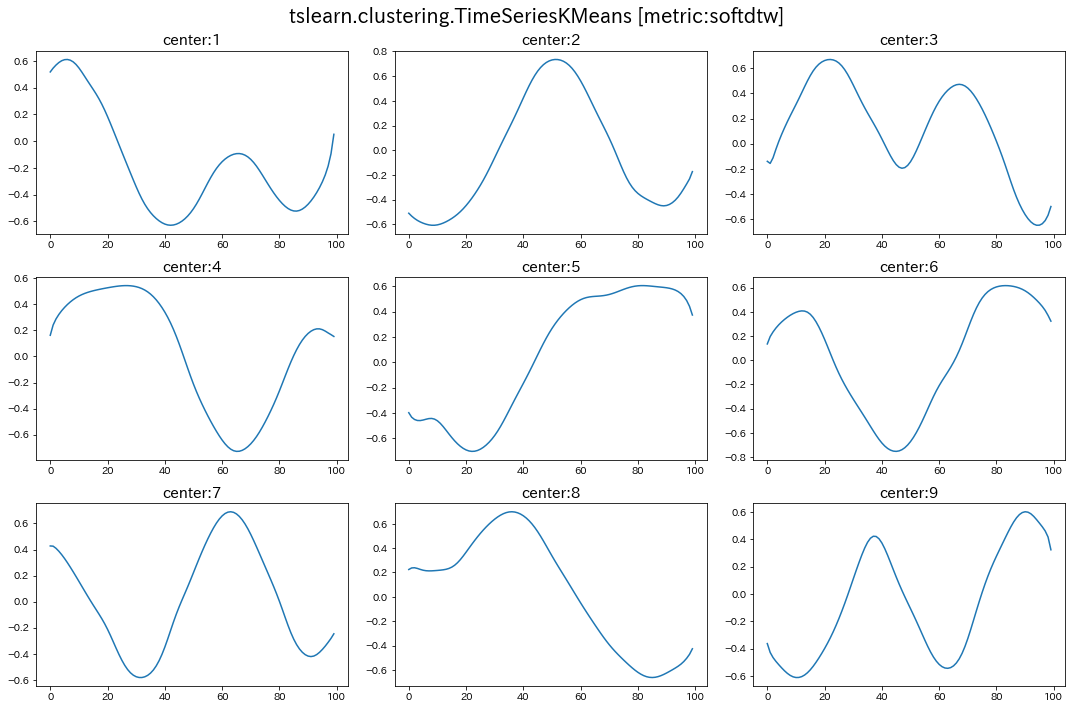

In [30]:
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:softdtw]'
show_cluster(km3, suptitle, 'center')

## エルボー法

In [31]:
distortions = []
tskms = []
for n in range(1, 11):
    print('n_clusters:', n)
    km = TimeSeriesKMeans(n_clusters=n, metric='dtw', random_state=0)
    km.fit(A)
    tskms.append(km)
    distortions.append(km.inertia_)

n_clusters: 1
n_clusters: 2
n_clusters: 3
n_clusters: 4
n_clusters: 5
n_clusters: 6
n_clusters: 7
n_clusters: 8
n_clusters: 9
n_clusters: 10


In [32]:
# 作成したモデルを保存しておく
for i in range(len(tskms)):
    # print(i, f'data/tskm_cluster{i+1}.hdf5')
    file_path = f'data/tskm_cluster{i+1}.hdf5'
    if os.path.isfile(file_path):
        os.remove(file_path)
    tskms[i].to_hdf5(file_path)

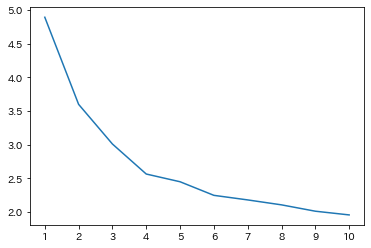

In [33]:
plt.plot(distortions)
plt.xticks(range(10), range(1,11))
plt.show()

## シルエット法

In [34]:
# 保存されたファイルからロードする場合は以下を実施
tskms = []
for n in range(10):
    file_path = f'data/tskm_cluster{n+1}.hdf5'
    if os.path.isfile(file_path):
        print(f'Load: tskms[{n}]=',file_path, )
        tskms.append(TimeSeriesKMeans.from_hdf5(file_path))
    else:
        print('Skip: ',file_path)

Load: tskms[0]= data/tskm_cluster1.hdf5
Load: tskms[1]= data/tskm_cluster2.hdf5
Load: tskms[2]= data/tskm_cluster3.hdf5
Load: tskms[3]= data/tskm_cluster4.hdf5
Load: tskms[4]= data/tskm_cluster5.hdf5
Load: tskms[5]= data/tskm_cluster6.hdf5
Load: tskms[6]= data/tskm_cluster7.hdf5
Load: tskms[7]= data/tskm_cluster8.hdf5
Load: tskms[8]= data/tskm_cluster9.hdf5
Load: tskms[9]= data/tskm_cluster10.hdf5


In [35]:
silhouette_score(A, tskms[3].labels_, 'dtw')

0.22072428090707782

In [36]:
silhouette_score(A, tskms[5].labels_, 'dtw')

0.16626760725861936

In [37]:
silhouette_scores = []
for n in range(1, 10):
    print(f'calc.. silhouette score [cluster{n+1}]')
    ss = silhouette_score(A, tskms[n].labels_, 'dtw')
    silhouette_scores.append(ss)
    print(f'silhouette score [cluster{n+1}]: {ss}')

calc.. silhouette score [cluster2]


silhouette score [cluster2]: 0.2886742940088376
calc.. silhouette score [cluster3]
silhouette score [cluster3]: 0.2509953803568257
calc.. silhouette score [cluster4]
silhouette score [cluster4]: 0.22072428090707782
calc.. silhouette score [cluster5]
silhouette score [cluster5]: 0.16544602328564462
calc.. silhouette score [cluster6]
silhouette score [cluster6]: 0.16626760725861936
calc.. silhouette score [cluster7]
silhouette score [cluster7]: 0.17341160984864082
calc.. silhouette score [cluster8]
silhouette score [cluster8]: 0.1522276260254182
calc.. silhouette score [cluster9]
silhouette score [cluster9]: 0.13980725434015503
calc.. silhouette score [cluster10]
silhouette score [cluster10]: 0.13247826449902295


In [38]:
for i in range(len(silhouette_scores)):
    print(f'silhouette score [cluster{i+2}]: {round(silhouette_scores[i],3)}')

silhouette score [cluster2]: 0.289
silhouette score [cluster3]: 0.251
silhouette score [cluster4]: 0.221
silhouette score [cluster5]: 0.165
silhouette score [cluster6]: 0.166
silhouette score [cluster7]: 0.173
silhouette score [cluster8]: 0.152
silhouette score [cluster9]: 0.14
silhouette score [cluster10]: 0.132


## クラスタ数:4

In [39]:
# クラスタ数:4で実施
km4 = AozoraTSKmeas(4)
km4.fit_transform(A)

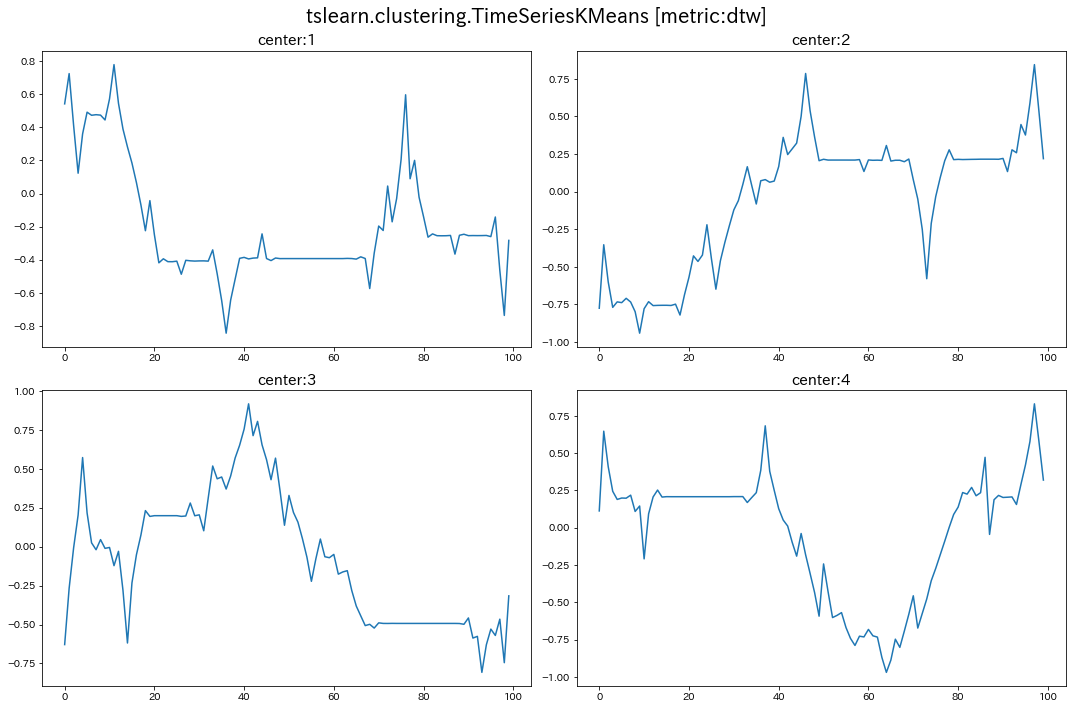

In [40]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km4.show_cluster(suptitle, 'center', 2, 2)

In [41]:
# クラスタ付近の小説を表示
km4.show_novels(df_merge, 5)

CLUSTER NUM:4
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 銭形平次捕物控 [089 百四十四夜] (野村 胡堂,589)
https://www.aozora.gr.jp/cards/001670/card56202.html
02: ジロリの女 (坂口 安吾,1460)
https://www.aozora.gr.jp/cards/001095/card42827.html
03: ガラマサどん (佐々木 邦,6131)
https://www.aozora.gr.jp/cards/001750/card57367.html
04: 甲乙 (泉 鏡花,617)
https://www.aozora.gr.jp/cards/000050/card48402.html
05: 銭形平次捕物控 [066 玉の輿の呪い] (野村 胡堂,523)
https://www.aozora.gr.jp/cards/001670/card56283.html

Top Stories of center2:
01: 平凡 (二葉亭 四迷,1937)
https://www.aozora.gr.jp/cards/000006/card3310.html
02: 銭形平次捕物控 [239 群盗] (野村 胡堂,665)
https://www.aozora.gr.jp/cards/001670/card57203.html
03: 大菩薩峠 [18 安房の国の巻] (中里 介山,2096)
https://www.aozora.gr.jp/cards/000283/card2934.html
04: 農村 (宮本 百合子,1154)
https://www.aozora.gr.jp/cards/000311/card7910.html
05: 鬼 (吉川 英治,554)
https://www.aozora.gr.jp/cards/001562/card52449.html

Top Stories of center3:
01: 右門捕物帖 [37 血の降るへや] (佐々木 味津三,732)
https://www.aozora.gr.jp/cards/000111/card557.html
02: 旧主人 (

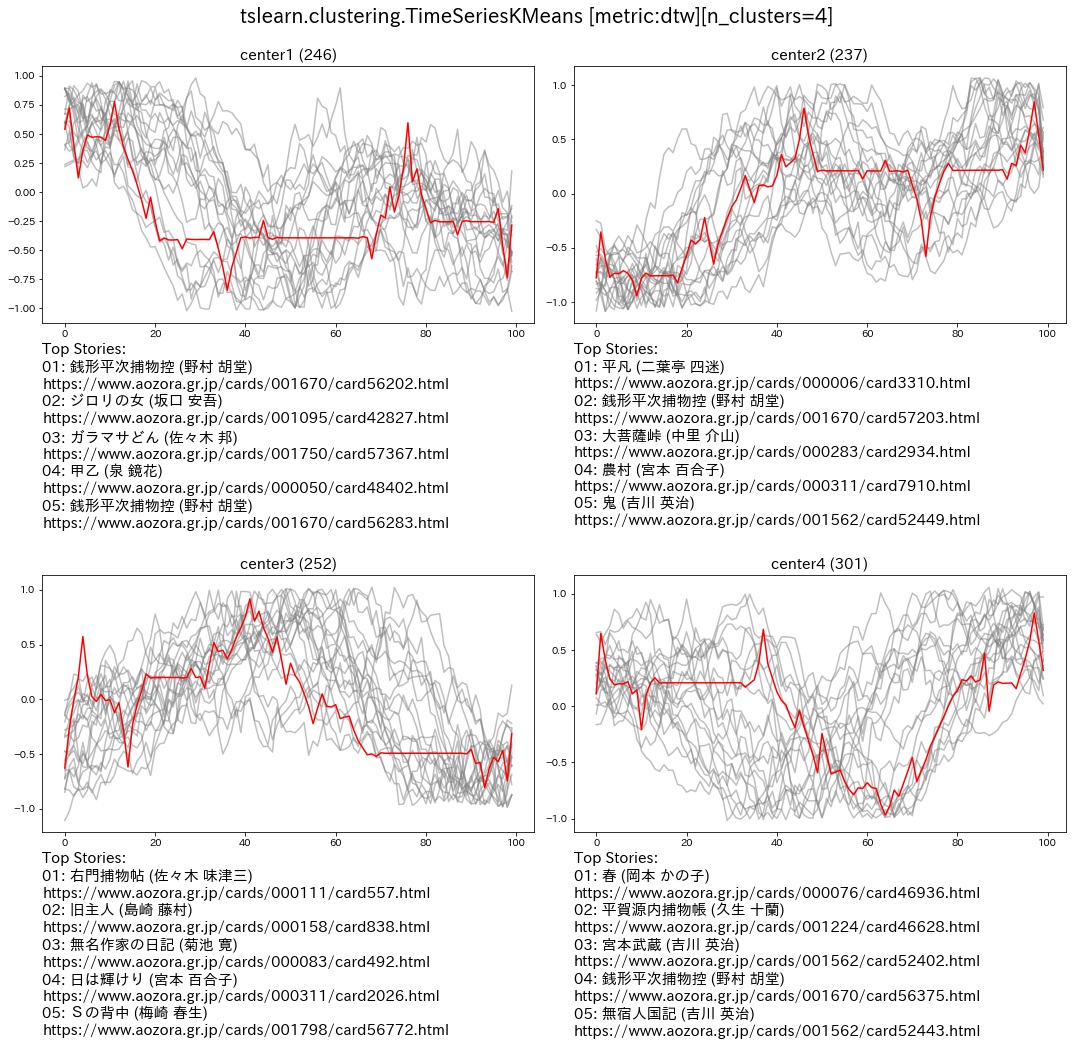

In [42]:
# クラスタとその付近の小説を視覚化
km4.show_cluster_sumples(df_merge, plot_rows=2, plot_cols=2)

## クラスタ数:5

In [43]:
# クラスタ数:5で実施
km5 = AozoraTSKmeas(5)
km5.fit_transform(A)

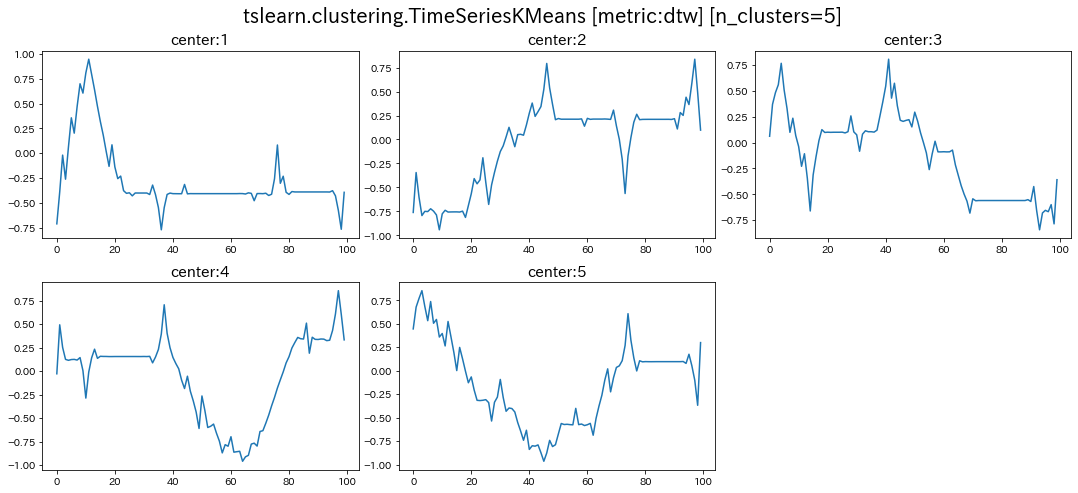

In [44]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] [n_clusters=5]'
km5.show_cluster(suptitle, 'center')

In [45]:
# クラスタ付近の小説を表示
km5.show_novels(df_merge, 5)

CLUSTER NUM:5
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 大菩薩峠 [13 如法闇夜の巻] (中里 介山,2285)
https://www.aozora.gr.jp/cards/000283/card1727.html
02: 死の予告 (野村 胡堂,531)
https://www.aozora.gr.jp/cards/001670/card56709.html
03: 風 (壺井 栄,1394)
https://www.aozora.gr.jp/cards/001875/card60070.html
04: 古き小画 (宮本 百合子,2006)
https://www.aozora.gr.jp/cards/000311/card1952.html
05: 銭形平次捕物控 [068 辻斬綺談] (野村 胡堂,527)
https://www.aozora.gr.jp/cards/001670/card56274.html

Top Stories of center2:
01: 平凡 (二葉亭 四迷,1937)
https://www.aozora.gr.jp/cards/000006/card3310.html
02: 銭形平次捕物控 [239 群盗] (野村 胡堂,665)
https://www.aozora.gr.jp/cards/001670/card57203.html
03: 農村 (宮本 百合子,1154)
https://www.aozora.gr.jp/cards/000311/card7910.html
04: ズラかった信吉 (宮本 百合子,2146)
https://www.aozora.gr.jp/cards/000311/card1979.html
05: その人 (小山 清,535)
https://www.aozora.gr.jp/cards/001867/card58192.html

Top Stories of center3:
01: 湖畔亭事件 (江戸川 乱歩,1753)
https://www.aozora.gr.jp/cards/001779/card58039.html
02: 薄紅梅 (泉 鏡花,1937)
https://www.aoz

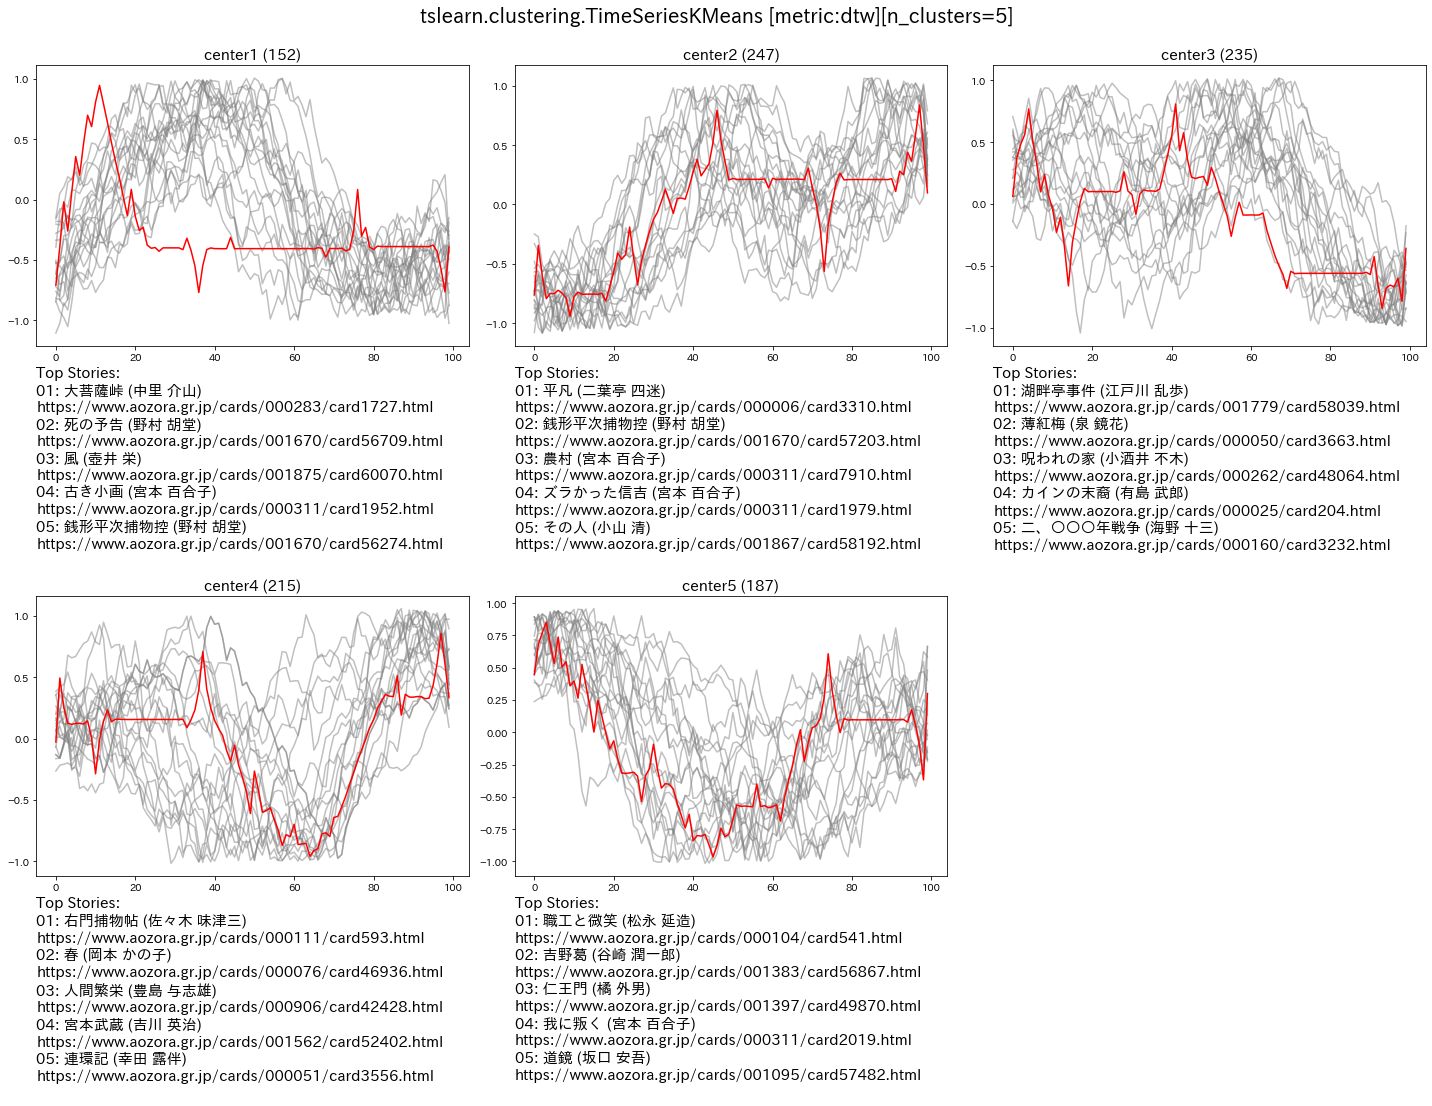

In [46]:
# クラスタとその付近の小説を視覚化
km5.show_cluster_sumples(df_merge, plot_rows=3, plot_cols=3, figsize=(20, 20))

## クラスタ数:6

In [47]:
# クラスタ数:6で実施
km6 = AozoraTSKmeas(6)
km6.fit_transform(A)

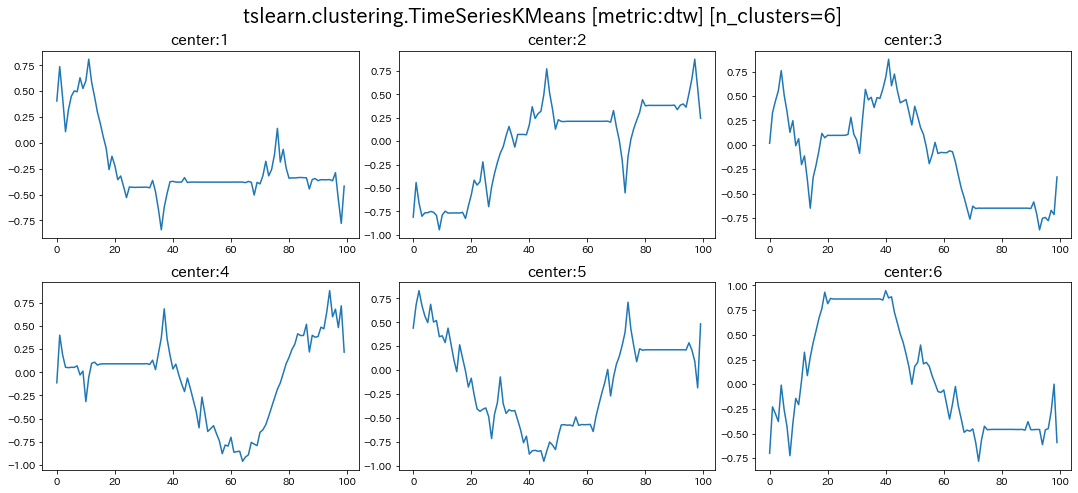

In [48]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw] [n_clusters=6]'
km6.show_cluster(suptitle, 'center')

In [49]:
# クラスタ付近の小説を表示
km6.show_novels(df_merge, 5)

CLUSTER NUM:6
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 銭形平次捕物控 [089 百四十四夜] (野村 胡堂,589)
https://www.aozora.gr.jp/cards/001670/card56202.html
02: 蒲団 (田山 花袋,1365)
https://www.aozora.gr.jp/cards/000214/card1669.html
03: 廃める (伊藤 左千夫,521)
https://www.aozora.gr.jp/cards/000058/card56540.html
04: 肌色の月 (久生 十蘭,1380)
https://www.aozora.gr.jp/cards/001224/card46147.html
05: 明治開化　安吾捕物 [03 その二　密室大犯罪] (坂口 安吾,712)
https://www.aozora.gr.jp/cards/001095/card43205.html

Top Stories of center2:
01: 平凡 (二葉亭 四迷,1937)
https://www.aozora.gr.jp/cards/000006/card3310.html
02: 鬼 (吉川 英治,554)
https://www.aozora.gr.jp/cards/001562/card52449.html
03: 大菩薩峠 [18 安房の国の巻] (中里 介山,2096)
https://www.aozora.gr.jp/cards/000283/card2934.html
04: 銭形平次捕物控 [239 群盗] (野村 胡堂,665)
https://www.aozora.gr.jp/cards/001670/card57203.html
05: 半七捕物帳 [58 菊人形の昔] (岡本 綺堂,505)
https://www.aozora.gr.jp/cards/000082/card987.html

Top Stories of center3:
01: 湖畔亭事件 (江戸川 乱歩,1753)
https://www.aozora.gr.jp/cards/001779/card58039.html
02: 薄紅梅

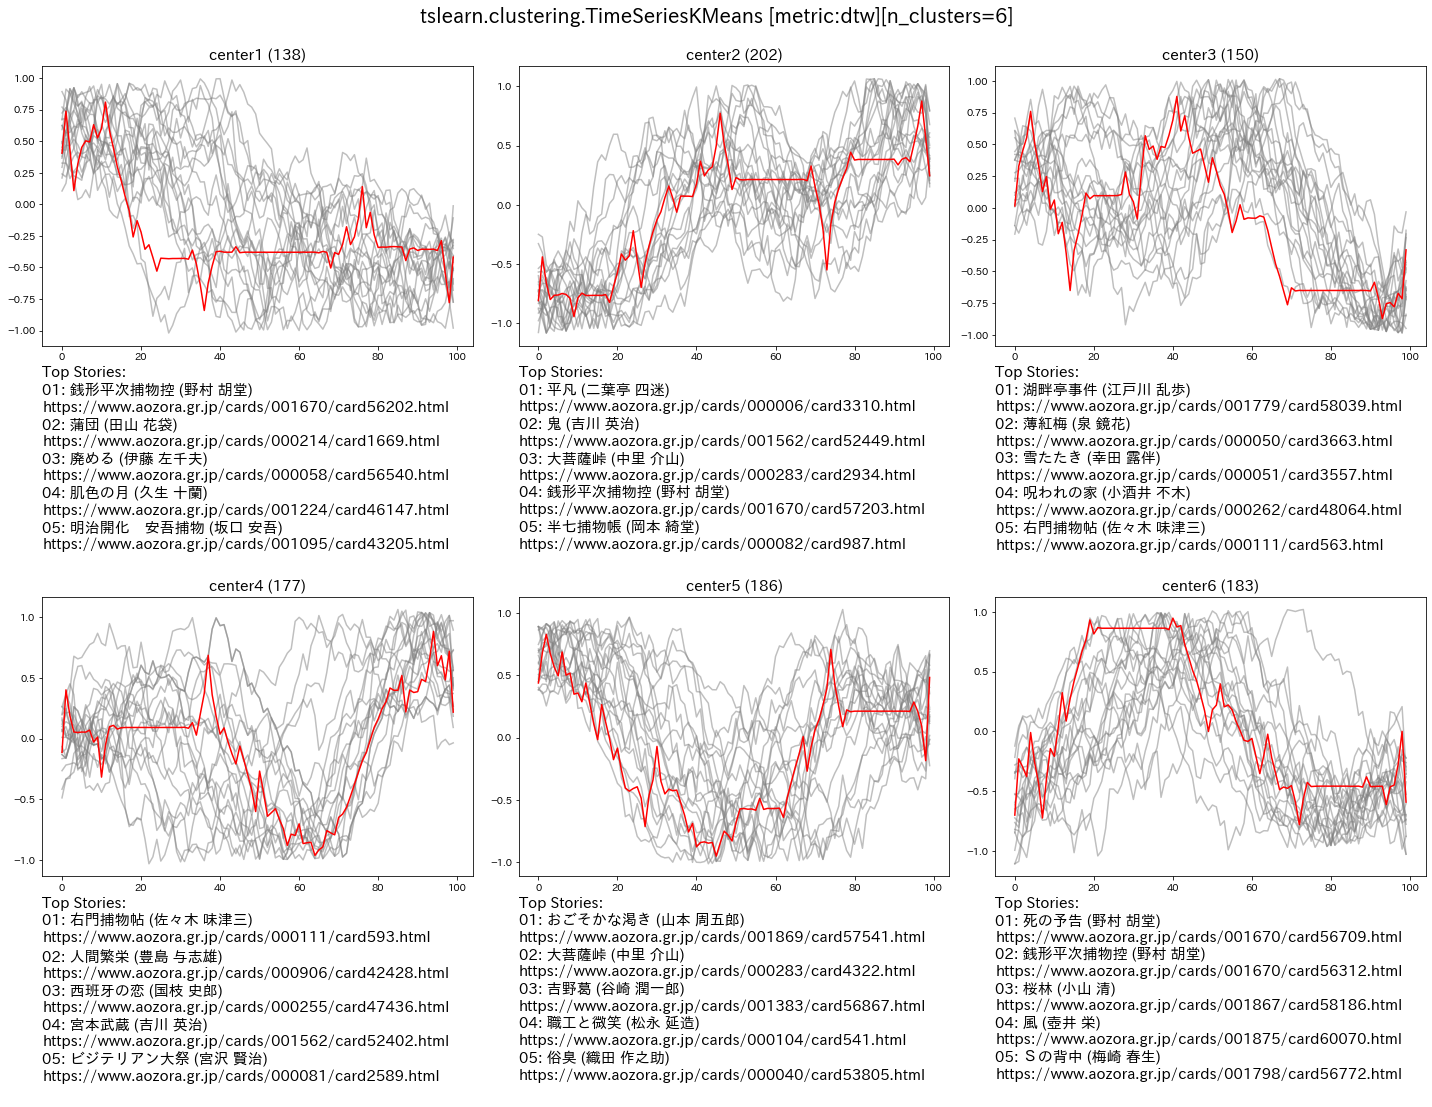

In [50]:
# クラスタとその付近の小説を視覚化
km6.show_cluster_sumples(df_merge, plot_rows=3, plot_cols=3, figsize=(20, 20))

## クラスタ数:7

In [51]:
# クラスタ数4で実施
km7 = AozoraTSKmeas(7)
km7.fit_transform(A)


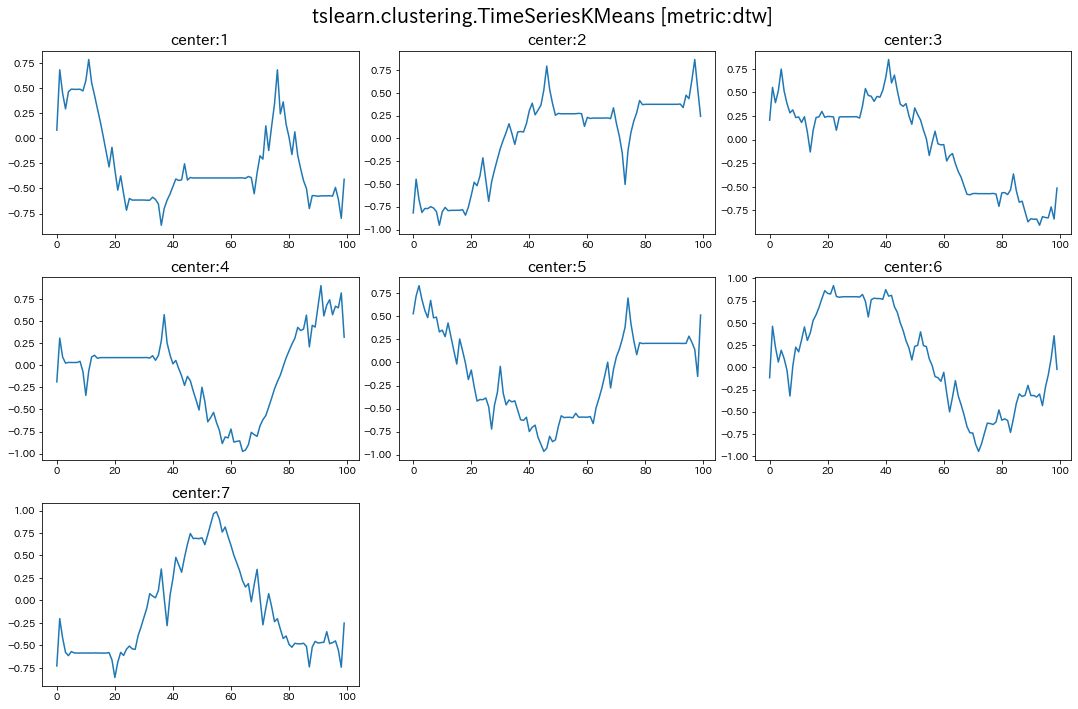

In [52]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km7.show_cluster(suptitle, 'center')

In [53]:
# クラスタ付近の小説を表示
km7.show_novels(df_merge, 5)

CLUSTER NUM:7
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 銭形平次捕物控 [089 百四十四夜] (野村 胡堂,589)
https://www.aozora.gr.jp/cards/001670/card56202.html
02: 銭形平次捕物控 [066 玉の輿の呪い] (野村 胡堂,523)
https://www.aozora.gr.jp/cards/001670/card56283.html
03: ガラマサどん (佐々木 邦,6131)
https://www.aozora.gr.jp/cards/001750/card57367.html
04: 夢は呼び交す [――黙子覚書――] (蒲原 有明,3604)
https://www.aozora.gr.jp/cards/001055/card43739.html
05: 大菩薩峠 [03 壬生と島原の巻 ] (中里 介山,1736)
https://www.aozora.gr.jp/cards/000283/card3227.html

Top Stories of center2:
01: 平凡 (二葉亭 四迷,1937)
https://www.aozora.gr.jp/cards/000006/card3310.html
02: 鬼 (吉川 英治,554)
https://www.aozora.gr.jp/cards/001562/card52449.html
03: 銭形平次捕物控 [239 群盗] (野村 胡堂,665)
https://www.aozora.gr.jp/cards/001670/card57203.html
04: その人 (小山 清,535)
https://www.aozora.gr.jp/cards/001867/card58192.html
05: 姫たちばな (室生 犀星,542)
https://www.aozora.gr.jp/cards/001579/card56459.html

Top Stories of center3:
01: 爆弾太平記 (夢野 久作,1419)
https://www.aozora.gr.jp/cards/000096/card2102.html
02: 

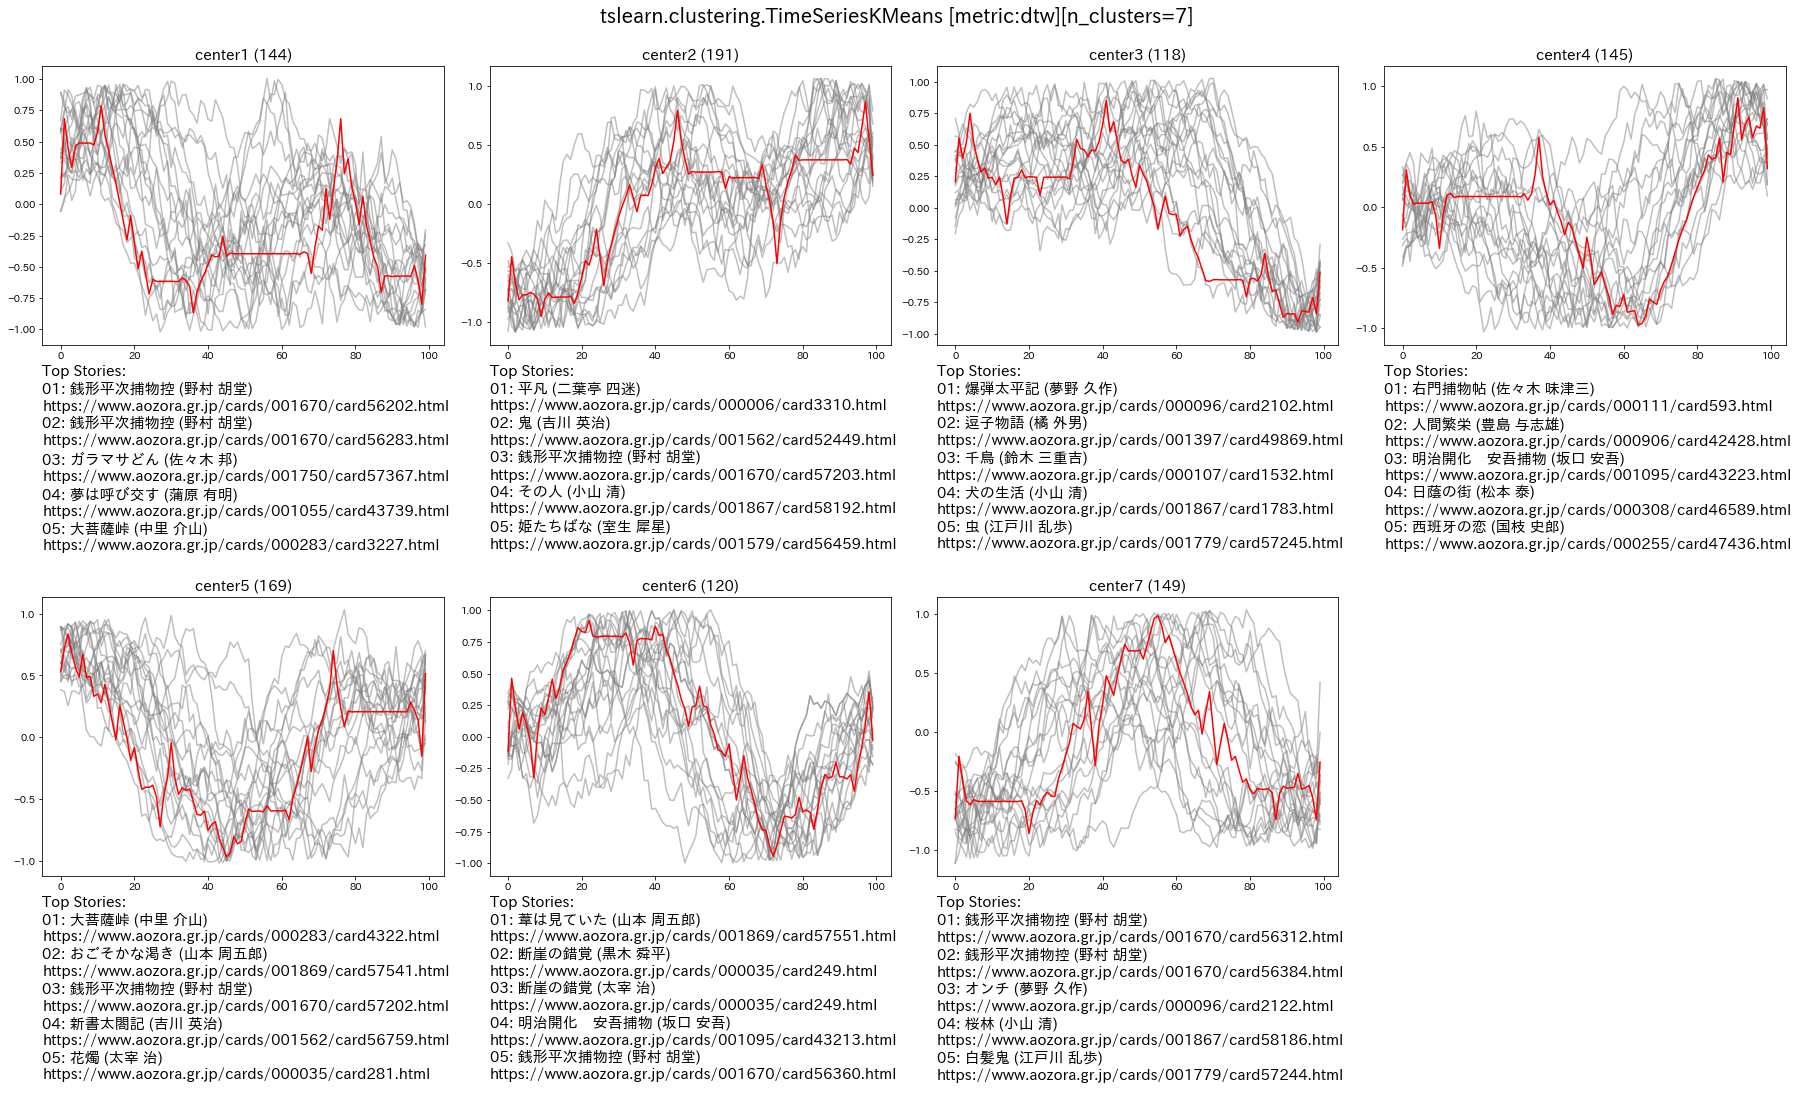

In [54]:
# クラスタとその付近の小説を視覚化
km7.show_cluster_sumples(df_merge, figsize=(25, 20), plot_rows=3, plot_cols=4)

## クラスタ数:8

In [55]:
# クラスタ数8で実施
km8 = AozoraTSKmeas(8)
km8.fit_transform(A)

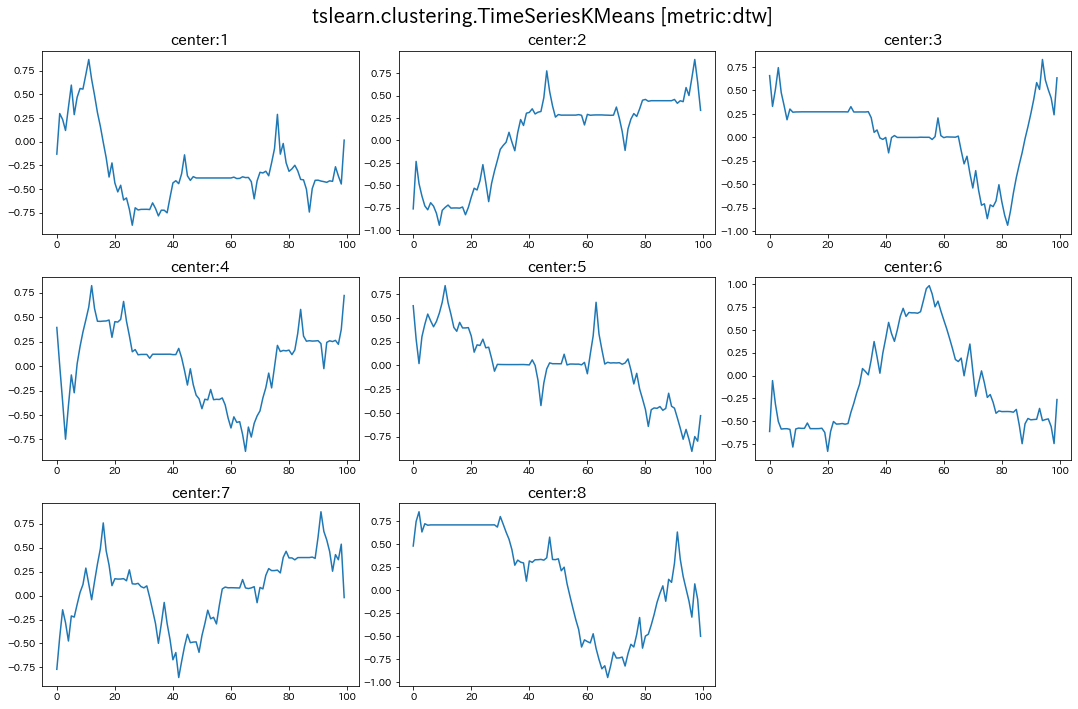

In [56]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km8.show_cluster(suptitle, 'center')

In [57]:
# クラスタ付近の小説を表示
km8.show_novels(df_merge, 5)

CLUSTER NUM:8
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 銭形平次捕物控 [243 猿回し] (野村 胡堂,776)
https://www.aozora.gr.jp/cards/001670/card57199.html
02: 家 [02 （下）] (島崎 藤村,4758)
https://www.aozora.gr.jp/cards/000158/card1510.html
03: 斗南先生 (中島 敦,532)
https://www.aozora.gr.jp/cards/000119/card1741.html
04: 夢は呼び交す [――黙子覚書――] (蒲原 有明,3604)
https://www.aozora.gr.jp/cards/001055/card43739.html
05: 三国志 [02 桃園の巻] (吉川 英治,6041)
https://www.aozora.gr.jp/cards/001562/card52410.html

Top Stories of center2:
01: その人 (小山 清,535)
https://www.aozora.gr.jp/cards/001867/card58192.html
02: 平凡 (二葉亭 四迷,1937)
https://www.aozora.gr.jp/cards/000006/card3310.html
03: 姫たちばな (室生 犀星,542)
https://www.aozora.gr.jp/cards/001579/card56459.html
04: 鬼 (吉川 英治,554)
https://www.aozora.gr.jp/cards/001562/card52449.html
05: 鍵 (谷崎 潤一郎,2201)
https://www.aozora.gr.jp/cards/001383/card56846.html

Top Stories of center3:
01: 陰獣トリステサ (橘 外男,1922)
https://www.aozora.gr.jp/cards/001397/card51243.html
02: 古今集巻之五 (山本 周五郎,538)
https://www.

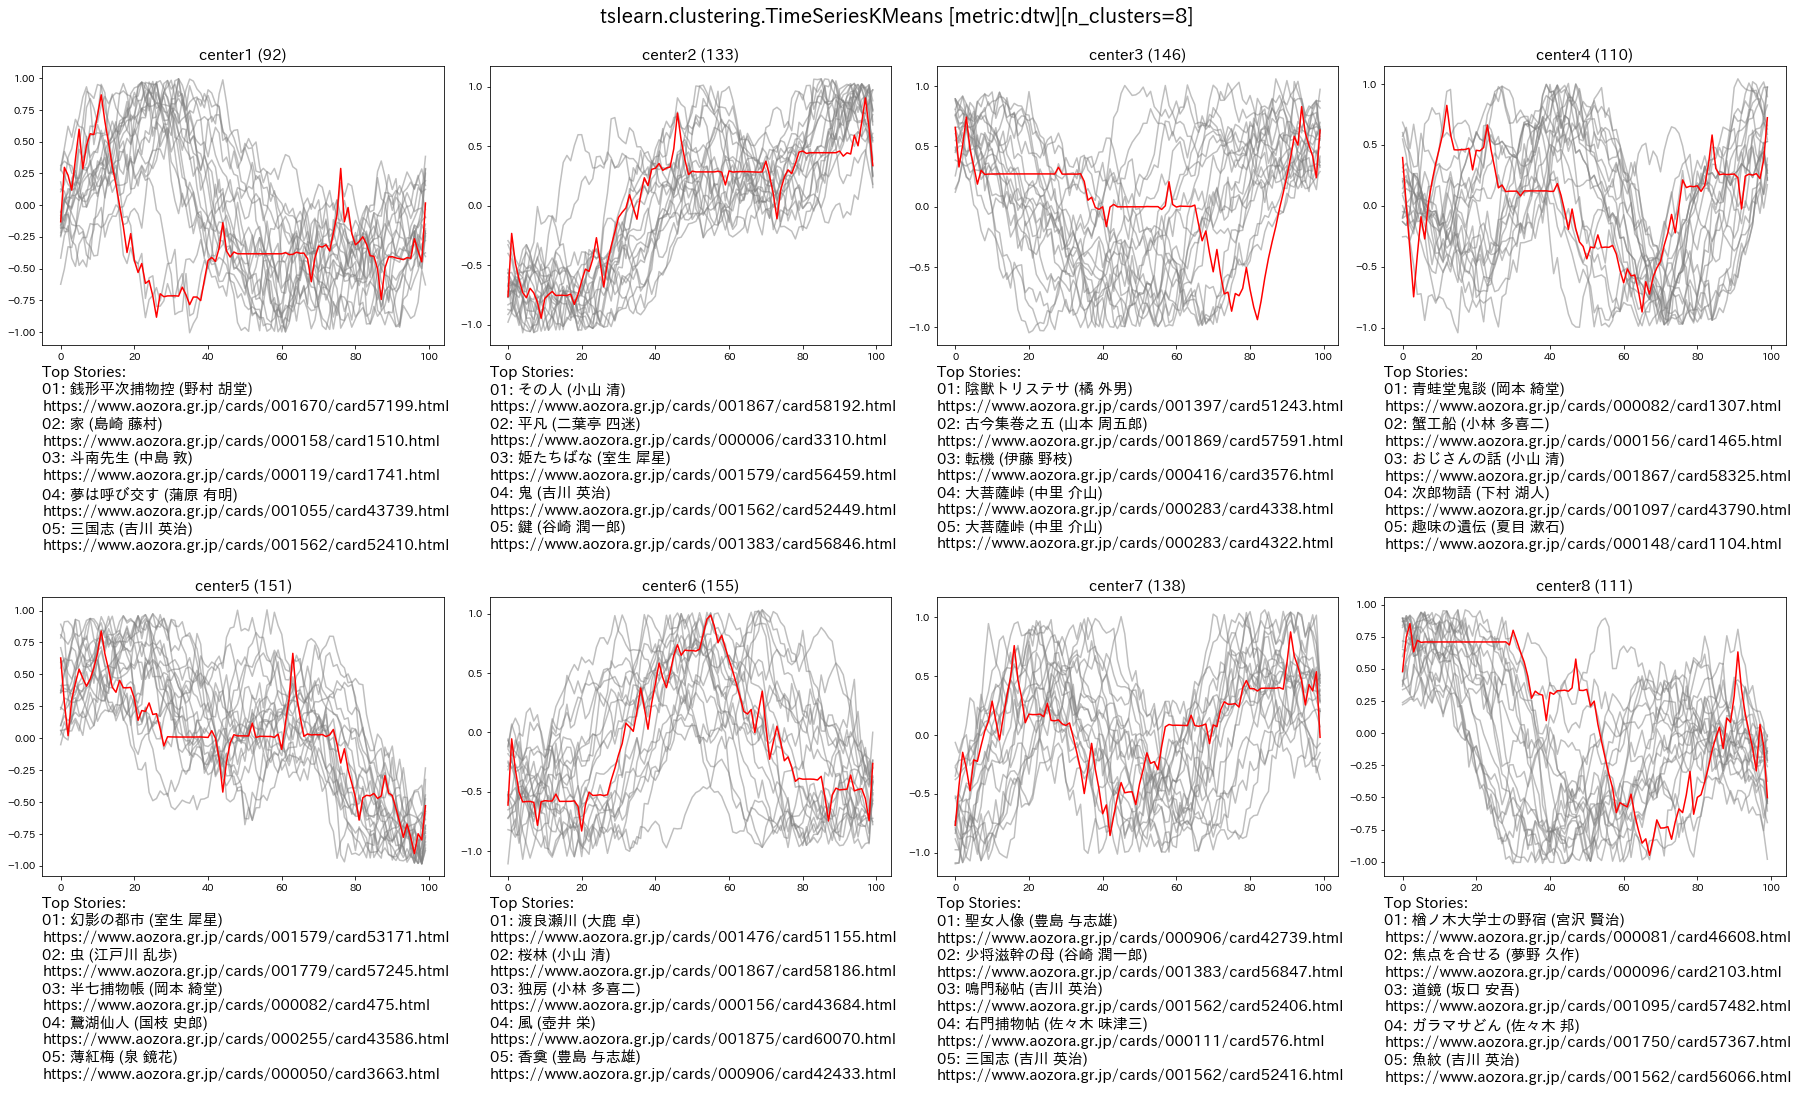

In [58]:
# クラスタとその付近の小説を視覚化
km8.show_cluster_sumples(df_merge, figsize=(25, 20), plot_rows=3, plot_cols=4)

## クラスタ数:9

In [59]:
# クラスタ数9で実施
km9 = AozoraTSKmeas(9)
km9.fit_transform(A)

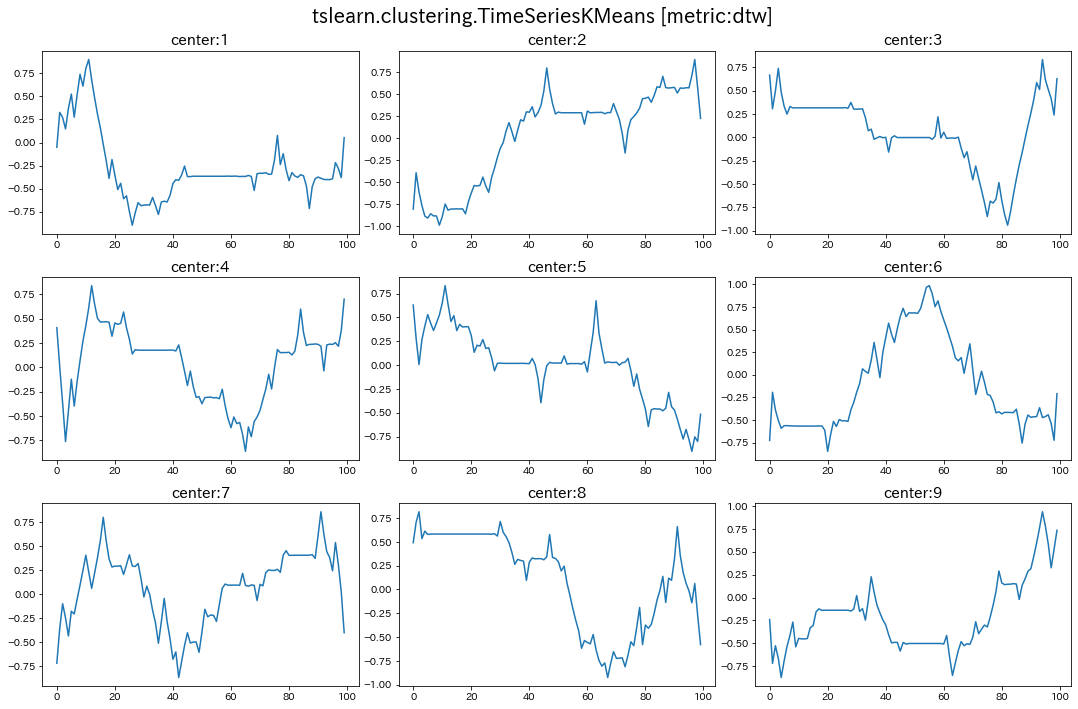

In [60]:
# 視覚化
suptitle = 'tslearn.clustering.TimeSeriesKMeans [metric:dtw]'
km9.show_cluster(suptitle, 'center')

In [61]:
# クラスタ付近の小説を表示
km9.show_novels(df_merge, 5)

CLUSTER NUM:9
NO: 作品名 [副題] (作者,文の長さ)

Top Stories of center1:
01: 銭形平次捕物控 [243 猿回し] (野村 胡堂,776)
https://www.aozora.gr.jp/cards/001670/card57199.html
02: 明治開化　安吾捕物 [11 その十　冷笑鬼] (坂口 安吾,607)
https://www.aozora.gr.jp/cards/001095/card43213.html
03: 大菩薩峠 [12 伯耆の安綱の巻] (中里 介山,1347)
https://www.aozora.gr.jp/cards/000283/card4060.html
04: 家 [02 （下）] (島崎 藤村,4758)
https://www.aozora.gr.jp/cards/000158/card1510.html
05: いさましい話 (山本 周五郎,998)
https://www.aozora.gr.jp/cards/001869/card57543.html

Top Stories of center2:
01: その人 (小山 清,535)
https://www.aozora.gr.jp/cards/001867/card58192.html
02: 姫たちばな (室生 犀星,542)
https://www.aozora.gr.jp/cards/001579/card56459.html
03: 平凡 (二葉亭 四迷,1937)
https://www.aozora.gr.jp/cards/000006/card3310.html
04: 脚 (吉川 英治,540)
https://www.aozora.gr.jp/cards/001562/card52446.html
05: 鍵 (谷崎 潤一郎,2201)
https://www.aozora.gr.jp/cards/001383/card56846.html

Top Stories of center3:
01: 転機 (伊藤 野枝,810)
https://www.aozora.gr.jp/cards/000416/card3576.html
02: 古今集巻之五 (山本 周五郎,538)
https:

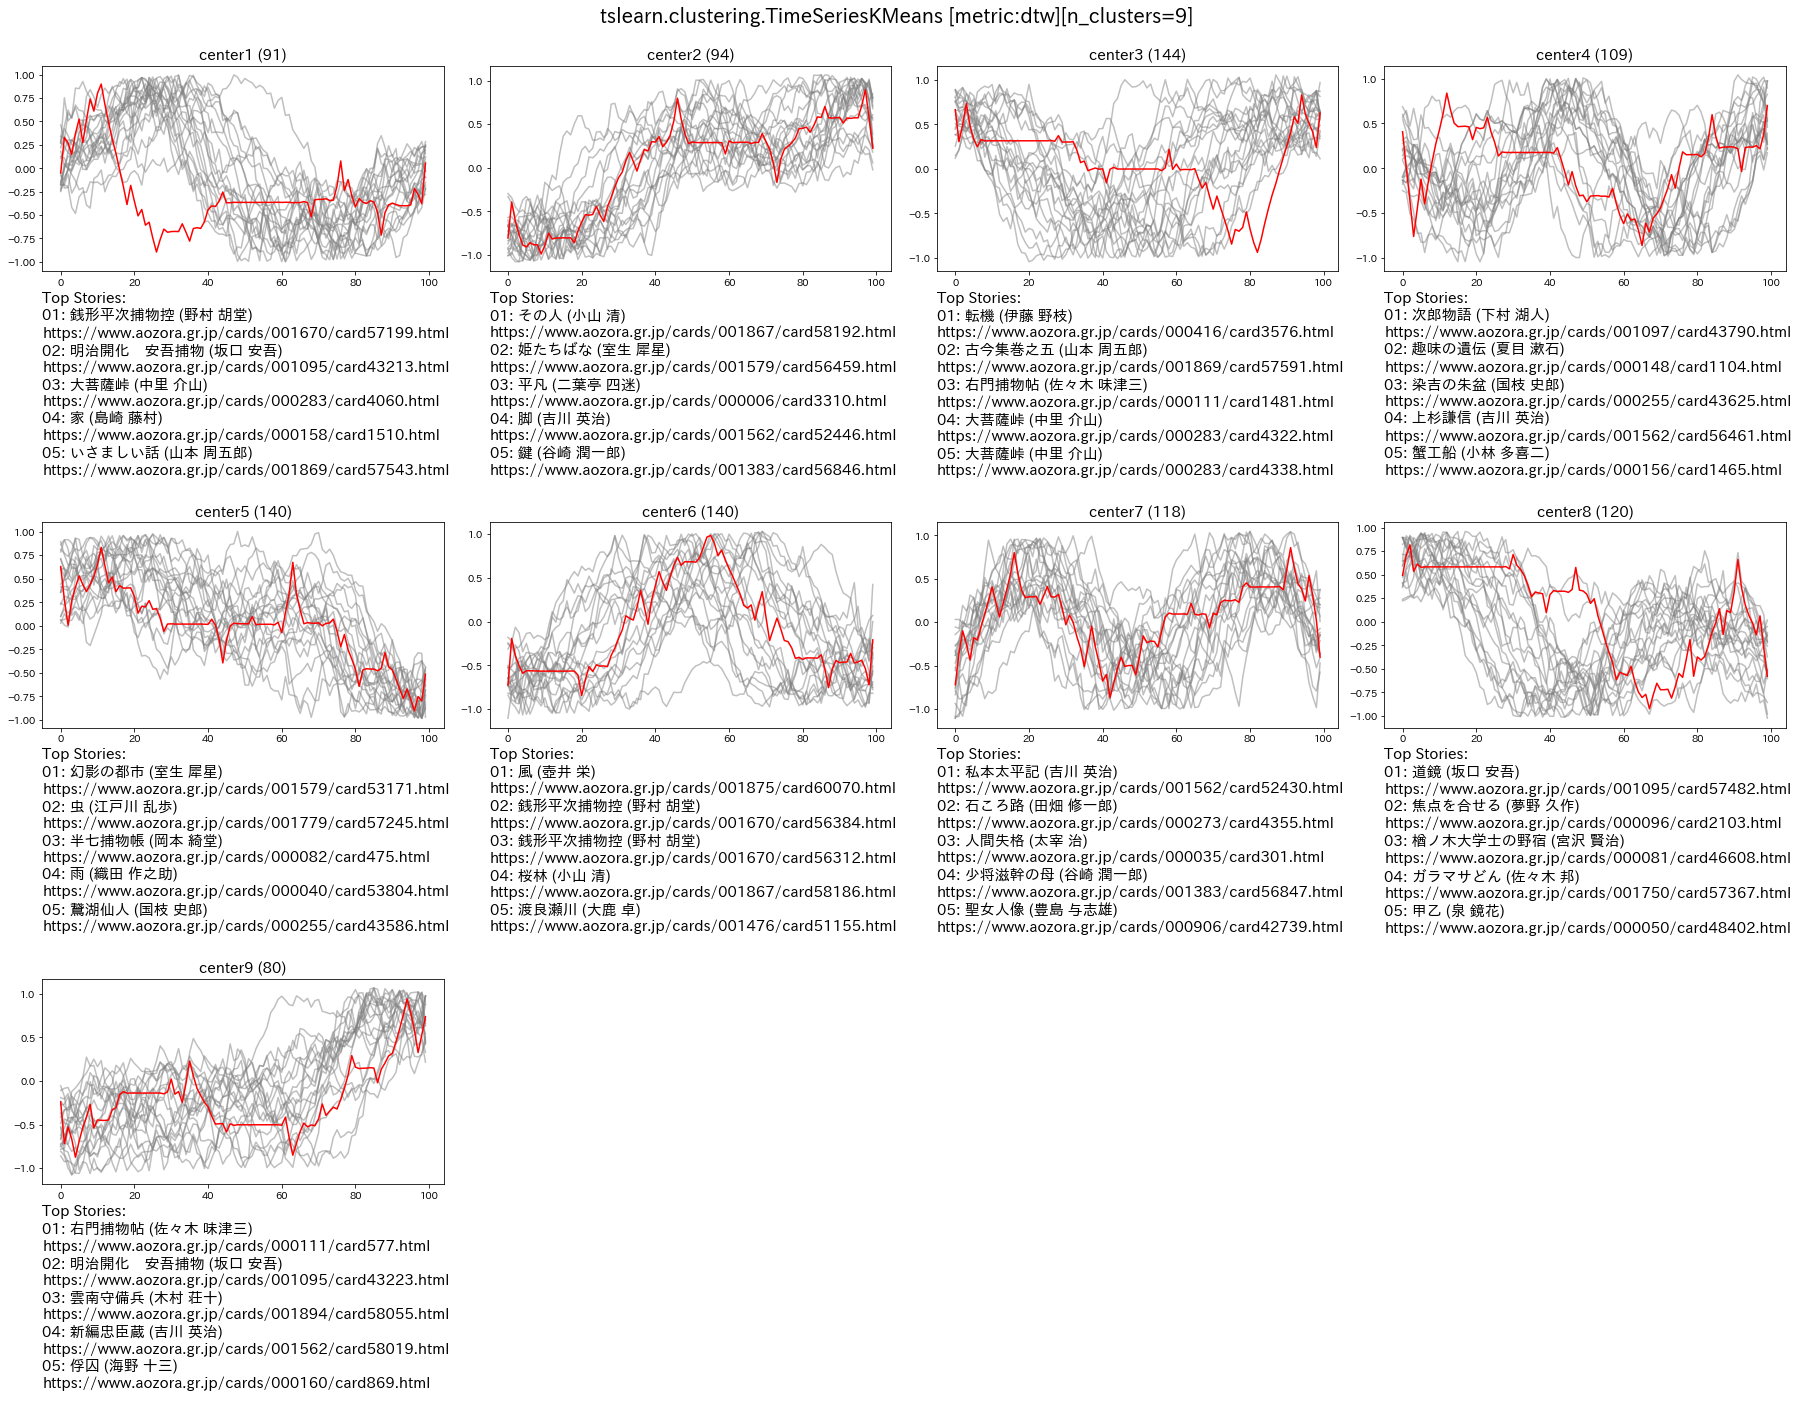

In [62]:
# クラスタとその付近の小説を視覚化
km9.show_cluster_sumples(df_merge, figsize=(25, 20), plot_cols=4)